In [183]:
# Import Libraries
from PIL import Image
import cv2
from plantcv import plantcv as pcv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [184]:
class options:
    def __init__(self):
        self.image = "testRGB.jpg"
        self.debug = "plot"
        self.writeimg= False
        self.result = "vis_nir_test_results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

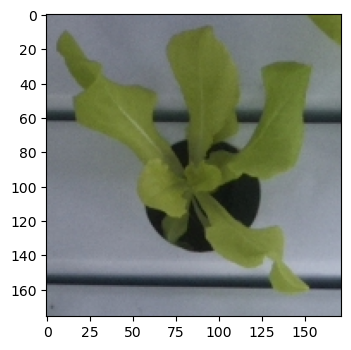

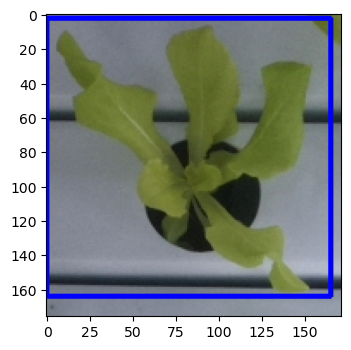

In [228]:
# Read image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)
# Crop image
img = pcv.crop(img=img, x=0, y=2, h=163, w=166)

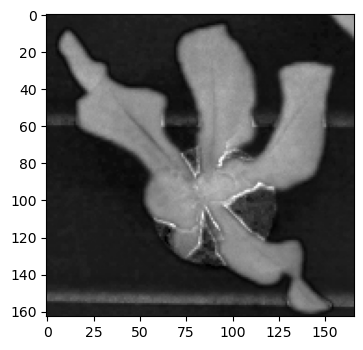

In [229]:
# Convert RGB to HSV and extract the saturation channel

# Inputs:
#   rgb_img - RGB image data 
#   channel - Split by 'h' (hue), 's' (saturation), or 'v' (value) channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')

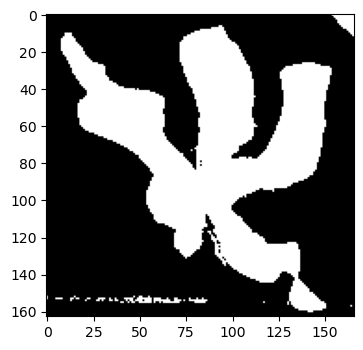

In [230]:
# Threshold the Saturation image

# Inputs:
#   gray_img - Grayscale image data 
#   threshold- Threshold value (between 0-255)
#   max_value - Value to apply above threshold (255 = white) 
#   object_type - 'light' (default) or 'dark'. If the object is lighter than the background then standard threshold is done.
#                 If the object is darker than the background then inverse thresholding is done. 
s_thresh = pcv.threshold.binary(gray_img=s, threshold=90, max_value=255, object_type='light')



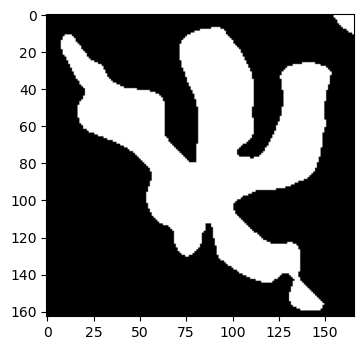

In [231]:
# Median Blur

# Inputs: 
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=7)

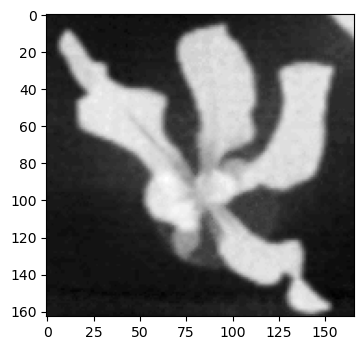

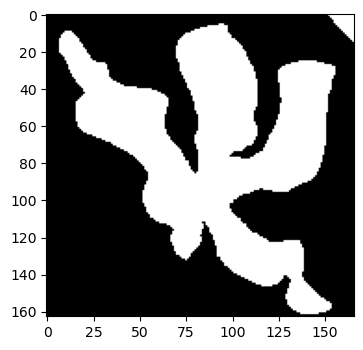

In [232]:
# Convert RGB to LAB and extract the blue-yellow channel

# Input:
#   rgb_img - RGB image data 
#   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue-yellow channel image
b_thresh = pcv.threshold.binary(gray_img=b, threshold=135, max_value=255, object_type='light')

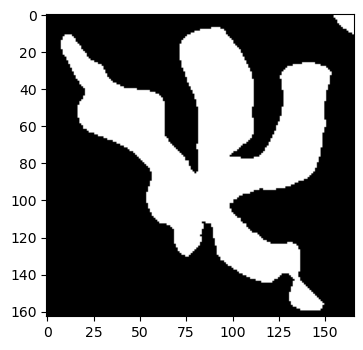

In [233]:
# Join the thresholded saturation and blue-yellow images

# Inputs: 
#   bin_img1 - Binary image data to be compared to bin_img2
#   bin_img2 - Binary image data to be compared to bin_img1
bs = pcv.logical_and(bin_img1=s_mblur, bin_img2=b_thresh)

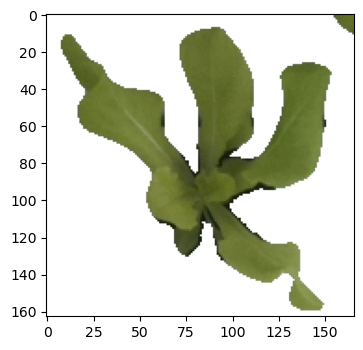

In [234]:
# Apply Mask

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
masked = pcv.apply_mask(img=img, mask=bs, mask_color='white')

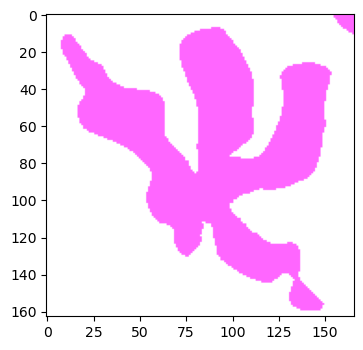

In [235]:
# Identify objects

# Inputs: 
#   img - RGB or grayscale image data for plotting 
#   mask - Binary mask used for detecting contours 
id_objects,obj_hierarchy = pcv.find_objects(img=masked, mask=bs)

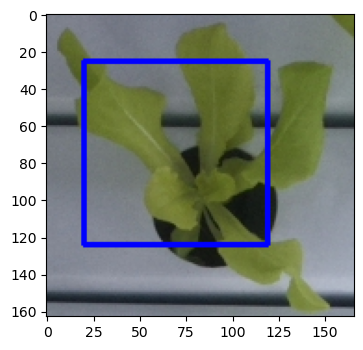

In [236]:
# This image is relatively large, and it's making it so not all sides of the ROI are showing up 
# when plotted in Jupyter. There is an optional line_thickness parameter in the params class.
# Default line_thickness = 5. 
pcv.params.line_thickness = 2


# Define Region of Interest (ROI) 

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 
roi1, roi_hierarchy = pcv.roi.rectangle(img=img, x=20, y=25, h=100, w=100)



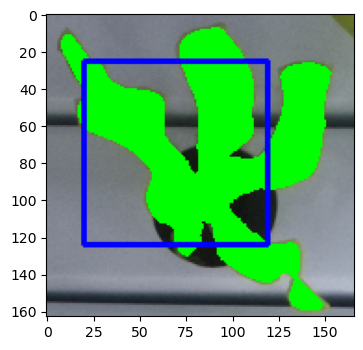

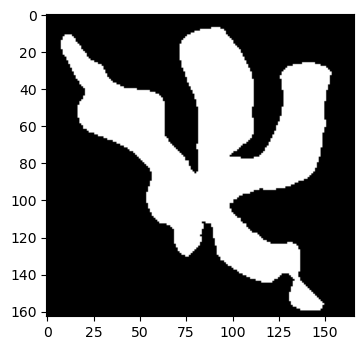

In [237]:
# Decide which objects to keep

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                              roi_hierarchy=roi_hierarchy,
                                                              object_contour=id_objects,
                                                              obj_hierarchy=obj_hierarchy,
                                                              roi_type='partial')



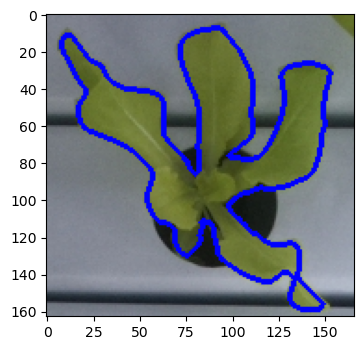

In [238]:
# Object combine the kept objects

# Inputs:
#   img - RGB or grayscale image data for plotting 
#   contours - Contour list 
#   hierarchy - Contour hierarchy array 
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy)

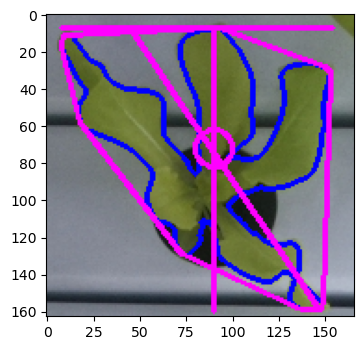

In [239]:
############### Analysis ################  
  
# Find shape properties

# Inputs:
#   img - RGB or grayscale image data 
#   obj- Single or grouped contour object
#   mask - Binary image mask to use as mask for moments analysis 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

analysis_image = pcv.analyze_object(img=img, obj=obj, mask=mask) # LABEL = "VIS" not working



/Users/garethtate/plantcv/plantcv/plantcv/acute_vertex.py:88: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


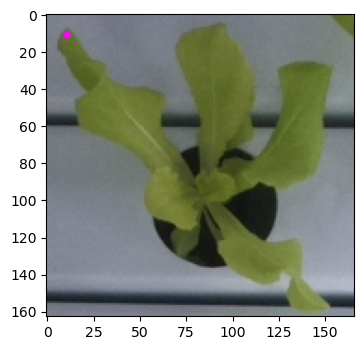

In [240]:
# Search for accute vertices 

# Inputs:
#   img - RGB or grayscale image 
#   obj - A contour of the plant object 
#   win - The pre and post point distances on which to calculate 
#            the angle of the focal point on which to calculate 
#            the angle
#   thresh - Threshold to set for acuteness
#   sep - The number of contour points to search within for the 
#         most acute value 
#   label -Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

acute_points_list, points_img = pcv.acute_vertex(img=img, obj=obj, win=30, thresh=25, sep=100)  # LABEL = "VIS" not working

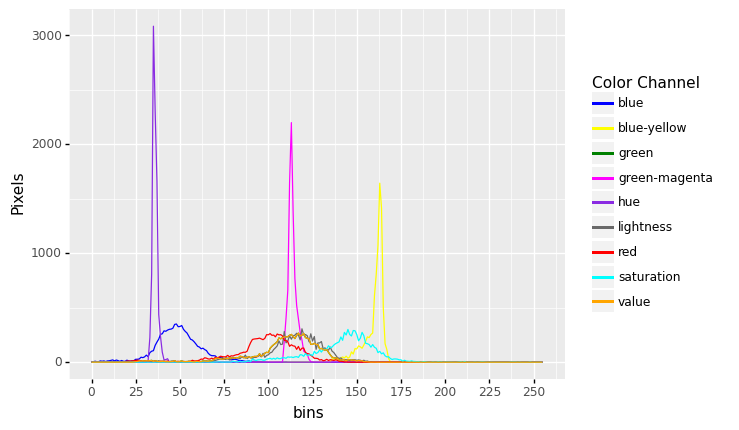

<ggplot: (8785396596249)>


In [241]:
# Determine color properties

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   hist_plot_type - None (default), 'all', 'rgb', 'lab', or 'hsv'
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

color_histogram = pcv.analyze_color(rgb_img=img, mask=kept_mask, hist_plot_type='all') #label="VIS"

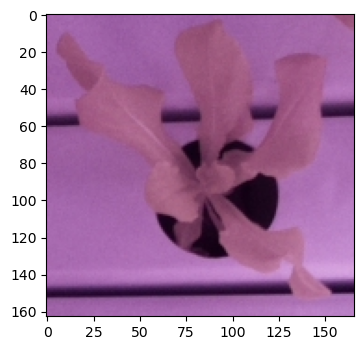

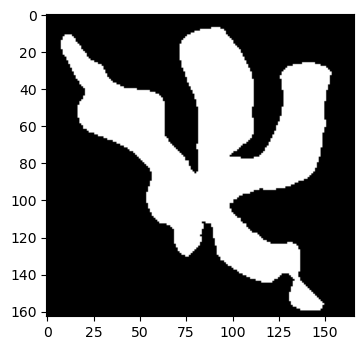

In [242]:
#nirpath = pcv.get_nir(path="./",filename="testRGB.jpg")
nir, path1, filename1 = pcv.readimage(filename="testNIR.jpg")

# Inputs:
#   img - RGB or grayscale image to resize
#   factors - Resizing factors (width, height). E.g. (0.5, 0.5)
#   interpolation - Interpolation method. Available options are "auto" = select method automatically (default), 
#   "area" = resampling using pixel area (OpenCV INTER_AREA), "bicubic" = bicubic interpolation (OpenCV INTER_CUBIC), 
#   "bilinear" = bilinear interpolation (OpenCV INTER_LINEAR), "lanczos" = Lanczos interpolation (OpenCV 
#   INTER_LANCZOS4), "nearest" = nearest-neighbor interpolation (OpenCV INTER_NEAREST).
nmask = pcv.transform.resize_factor(img=mask, factors=(1, 1))


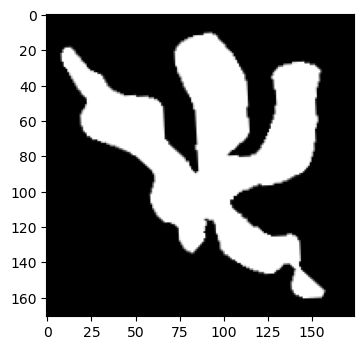

In [243]:
# Rotate the image slightly so the plants line up with 
# the grid that we'll add in a later step

# Inputs:
#   img = image object, RGB color space
#   rotation_deg = Rotation angle in degrees, can be negative, positive values 
#                  will move counter-clockwise 
#   crop = If True then image will be cropped to orginal image dimensions, if False
#          the image size will be adjusted to accommodate new image dimensions 
nmask = pcv.rotate(img=nmask, rotation_deg=3, crop=False)

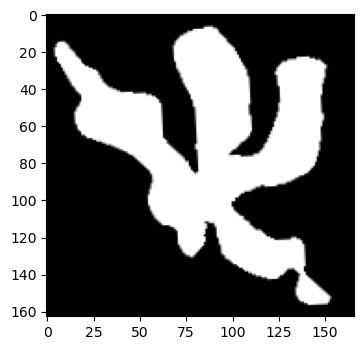

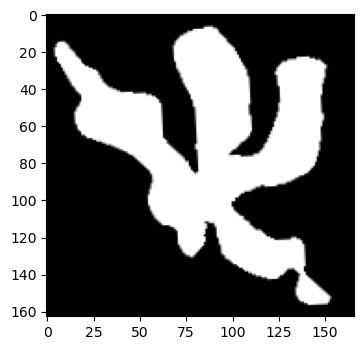

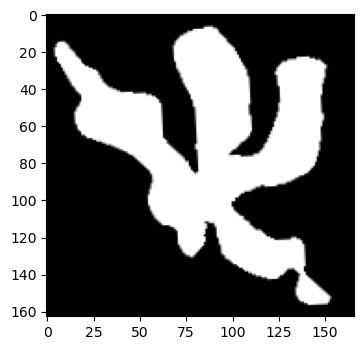

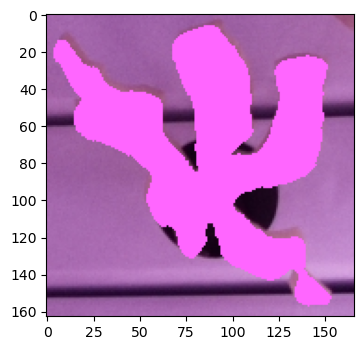

In [244]:
# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary image to be used as a mask 
#   x - Amount to push in the vertical direction
#   y - Amount to push in the horizontal direction
#   v_pos - Push from the 'top' (default) or 'bottom' in the vertical direction
#   h_pos - Push from the 'right' (default) or 'left' in the horizontal direction 
newmask = pcv.crop_position_mask(img=nir, mask=nmask, x=0, y=0, 
                                 v_pos="top", h_pos="right")

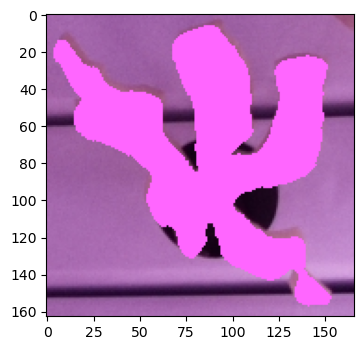

In [245]:


# Find objects in the new mask 
nir_objects, nir_hierarchy = pcv.find_objects(img=nir, mask=newmask)

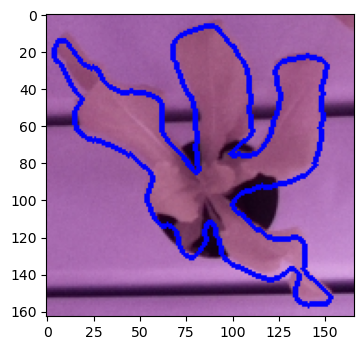

In [246]:
# Combine objects
nir_combined, nir_combinedmask = pcv.object_composition(img=nir, contours=nir_objects, 
                                                        hierarchy=nir_hierarchy)

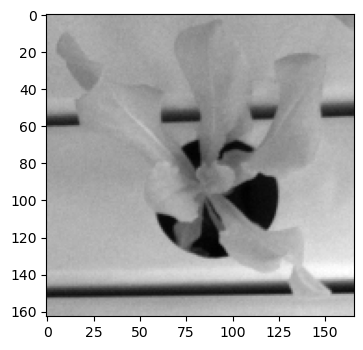

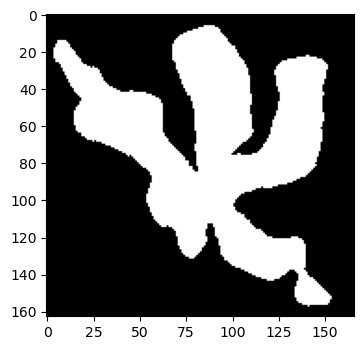

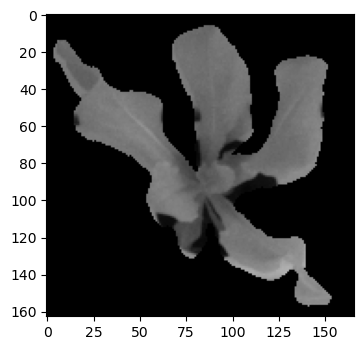

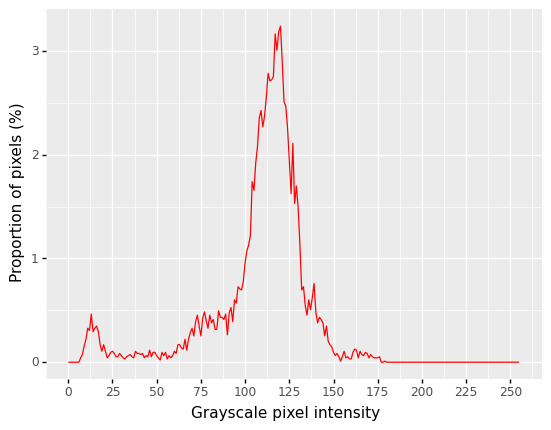

<ggplot: (8785428334425)>


In [247]:
# image converted from RGB to gray.
graynir = pcv.rgb2gray(rgb_img=nir)

# Analyze the NIR intensity 

# Inputs: 
#   gray_img - 8 or 16-bit grayscale image data 
#   mask - Binary mask made from selected contours 
#   bins - Number of classes to divide spectrum into
#   histplot - If True then plots histogram of intensity values, (default False) 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

nir_hist = pcv.analyze_nir_intensity(gray_img=graynir, mask=nir_combinedmask, 
                                     bins=256, histplot=True) #, label="NIR"

# If histplot=True then nir_hist contains the histogram plot. Otherwise it is an empty list. 
# Print out the nir histogram to save it.  
pcv.print_image(img=nir_hist, filename='vis_nir_tutorial_nir_hist.jpg')

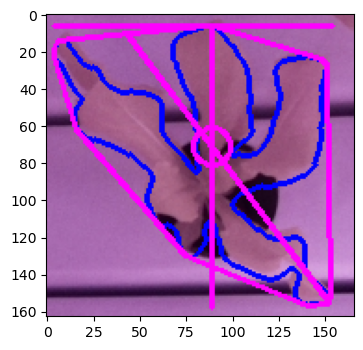

In [248]:
# Analyze the shape of the object 
nir_images = pcv.analyze_object(img=nir, obj=nir_combined, mask=nir_combinedmask) #, label="NIR"

In [249]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
#pcv.outputs.save_results(filename=args.result)

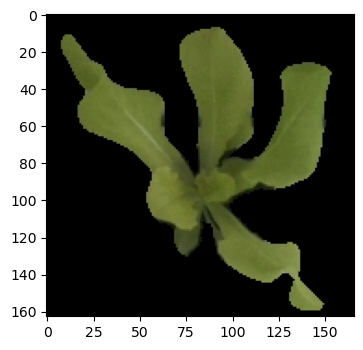

In [250]:
# Apply Mask

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
maskednewVIS = pcv.apply_mask(img=img, mask=kept_mask, mask_color='black')
pcv.print_image(maskednewVIS, "VISmasked.png")

In [251]:
VISimgNEW = Image.open("VISmasked.png")
VISimgR, VISimgG, VISimgB = VISimgNEW.split()

#VIS_arr = np.asarray(maskednewVIS)
#VIS_arr.shape

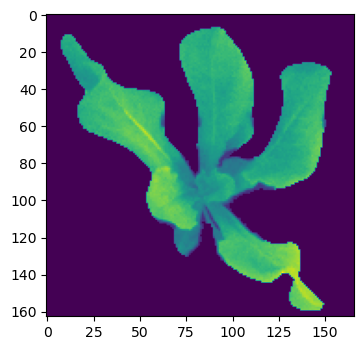

In [252]:
#VIS_red = VIS_arr.copy()
#VIS_red[:, :, 1] = 0    # Zero out contribution from green
#VIS_red[:, :, 2] = 0    # Zero out contribution from blue
plt.imshow(VISimgR)

In [253]:
VISarrR = np.asarray(VISimgR).astype('float')

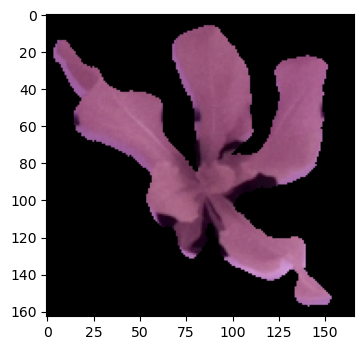

In [254]:
maskednewNIR = pcv.apply_mask(img=nir, mask=nir_combinedmask, mask_color='black')
pcv.print_image(maskednewNIR, "NIRmasked.png")

In [255]:
NIRimgNEW = Image.open("NIRmasked.png")
NIRimgR, NIRimgG, NIRimgB = NIRimgNEW.split()

#NIR_arr = np.asarray(maskednewNIR)
#VIS_arr.shape

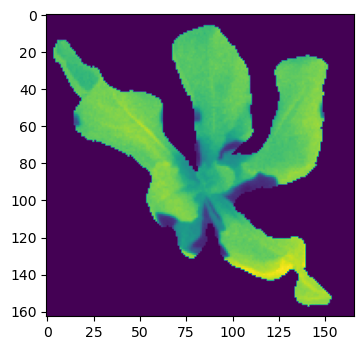

In [256]:
#RNIR_arr = VIS_arr.copy()
#RNIR_arr[:, :, 1] = 0    # Zero out contribution from green
#RNIR_arr[:, :, 2] = 0    # Zero out contribution from blue
plt.imshow(NIRimgR)

In [257]:
NIRarrR = np.asarray(NIRimgR).astype('float')

In [258]:
NIRarrNEW = np.asarray(NIRimgNEW)
VISarrNEW = np.asarray(VISimgNEW)

NIRarrNEW.shape

(163, 166, 3)

In [259]:
VISarrNEW.shape

(163, 166, 3)

In [260]:
NIRarrActual = NIRarrR-VISarrR

In [261]:
NIRredSUM = NIRarrActual+VISarrR
NIRredSUM[NIRredSUM ==0] = 0.01
NIRredSUM

array([[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]])

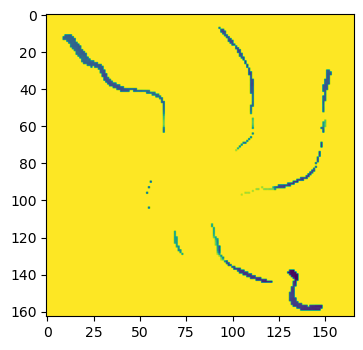

In [262]:
NDVI = (NIRarrActual-VISarrR)/(NIRredSUM)
plt.imshow(NDVI)